# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — мы её уже сделали.

Построим модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверим *accuracy* на тестовой выборке.

## Откроем и изучим файл

Импортируем библиотеки.

In [15]:
import pandas as pd
import math
import sklearn
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np
from sklearn.dummy import DummyClassifier

Прочитаем файл с данными.

In [16]:
df = pd.read_csv('/datasets/users_behavior.csv')

Изучим информацию о датафрейме и его первые 5 строк:

In [17]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Пропуски отсутствуют.

Сменим тип данных для столбцов "calls" и "messages" на целые числа, для удобства восприятия и расчетов в дальнейшем.

**Вывод:**

Данные не нуждаются в дополнительной обработке     

In [18]:
df['calls'] = df['calls'].astype('int64')
df['messages'] = df['messages'].astype('int64')

             calls   minutes  messages   mb_used  is_ultra
calls     1.000000  0.982083  0.177385  0.286442  0.207122
minutes   0.982083  1.000000  0.173110  0.280967  0.206955
messages  0.177385  0.173110  1.000000  0.195721  0.203830
mb_used   0.286442  0.280967  0.195721  1.000000  0.198568
is_ultra  0.207122  0.206955  0.203830  0.198568  1.000000


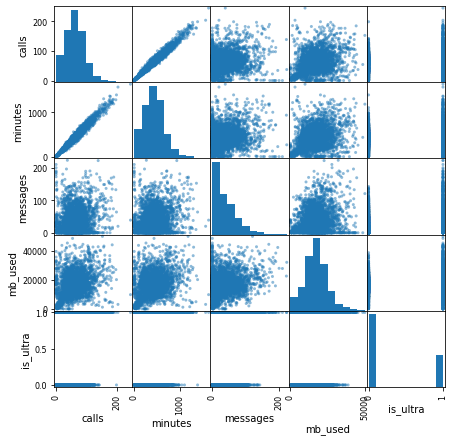

In [19]:
hwa = pd.read_csv('/datasets/users_behavior.csv')
pd.plotting.scatter_matrix(hwa, figsize=(7, 7)) 

print(hwa.corr())  

* Связь calls и calls указывает на то, что пользователи совершают более 200 звонков 
* Расход минут до 1000 расположен в количестве звонков до 200
* Основная масса сообщений до 100 отправляется пользователями которые тратят до 1000 минут и 3000 мегабайтов 

Что указывает на то, что пользователи чаще укладываются в лимиты тарифа. И то, что пользователи отдают предпочтение тарифу "Ультра"

## Разбъём данные на выборки

Разобъем данные на три выборки:  
* обучающую  
* валидационную  
* тестовую

In [20]:
#Убедимся в том, что наши экземпляры не разбиты на выборки по классам:
iris = load_iris()
df_train, df_test = iris.data, iris.target

print(f"Классы датасета: {iris.target}")

Классы датасета: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


Такой набор данных с тремя классами при равном числе экземпляров в каждом разделить на две выборки: 2/3 для обучения и 1/3 для тестирования, то полученные поднаборы будут иметь нулевое пересечение классовых меток. Это, очевидно, недопустимо при изучении признаков для предсказания классов. Необходимо это исправить.

In [21]:
df_train, df_test = train_test_split(df, train_size=0.25, random_state= 42)

print(f"Классы в y_train:\n{df_train}")
print(f"Классы в y_test:\n{df_test}")

Классы в y_train:
      calls  minutes  messages   mb_used  is_ultra
1968     98   738.62        79  21298.68         0
2938     41   310.21        16  14083.64         0
523     102   658.41        23  21392.68         0
2280    108   747.39        96  36266.22         0
1428     68   453.91        48  17788.66         0
...     ...      ...       ...       ...       ...
1095     62   454.02        35  15018.46         0
1130     69   465.96        12  14982.27         0
1294     40   280.44         2  13934.54         0
860      72   410.23        68  16006.55         0
3174     79   537.10        25  21223.37         0

[803 rows x 5 columns]
Классы в y_test:
      calls  minutes  messages   mb_used  is_ultra
506      46   338.60        35  11428.54         0
2513     39   242.71         0  20480.11         0
354      39   258.02         0  19998.80         0
1080     36   230.99        19  23525.07         1
2389     35   205.35        52  35177.94         1
...     ...      ...   

In [22]:
df_train, df_divide = train_test_split(df, test_size=0.25, random_state=12345) 

df_valid, df_test = train_test_split(df_divide, test_size=0.50, random_state=12345)

In [23]:
print(df.shape) 

(3214, 5)


## Исследуем модели

Целевой признак определим в переменной с обозначением target, а остальные разместим в features:

In [11]:
# Для обучающего датафрейма
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

# Для валидационного датафрейма
features_valid = df_valid.drop(['is_ultra'], axis=1)  
target_valid = df_valid['is_ultra']

Начнем с исследования модели дерева принятия решений.

Оценим в цикле долю правильных ответов для разных глубин дерева принятия решений:

In [12]:
for depth in range(1,10):
    model = DecisionTreeClassifier(random_state=0, max_depth=depth, min_samples_split= 100)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions)
    print('max_depth =',depth,': {:.4f}'.format(accuracy))

max_depth = 1 : 0.7637
max_depth = 2 : 0.7935
max_depth = 3 : 0.7985
max_depth = 4 : 0.8035
max_depth = 5 : 0.8035
max_depth = 6 : 0.7861
max_depth = 7 : 0.7935
max_depth = 8 : 0.7910
max_depth = 9 : 0.7960


Проверив разные варианты глубины лучший показатель 8035 начинался с 8. 

Оценим в цикле долю правильных ответов для разного количества оценщиков:

In [ ]:
%%time
for estimators in range(2,16):
    model = RandomForestClassifier(random_state=7529, n_estimators=estimators, max_depth=10)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions)
    print('n_estimators =',estimators,': {:.4f}'.format(accuracy))

Лучший результат у модели 9 accuracy 0.8134  

In [ ]:
predictions = model.predict(features_valid)
accuracy = accuracy_score(target_valid, predictions)
accuracy

Результат хуже, но и эту модель проверим на тестовой выборке.

Перейдем к логистической регрессии:

In [ ]:
model = LogisticRegression(random_state=12345)

model.fit(features_train, target_train)

predictions = model.predict(features_valid)

accuracy = accuracy_score(target_valid, predictions)

accuracy

Результат показал себя хуже, чем предыдущие: Случайного и Решающего деревьев. 

**Вывод:**  

Таким образом мы обучили модель дерева принятия решений и получили максимальный результат 10 = 0.7960. Далее обучили модель случайного леса, где макимальным был результат 9 = 0.8134. 

При обучении модели логической регрессии результат оказался наихудшим по сравнению с предыдущими.

## Проверьте модель на тестовой выборке

Перед проверкой модели разделим наш тестовый датафрейм на features и target:

In [ ]:
features_test = df_test.drop(['is_ultra'], axis=1)  
target_test = df_test['is_ultra']

Проверим модель на тестовой выборке:

In [ ]:
model = RandomForestClassifier(random_state=7529, n_estimators=10, max_depth=9)


model.fit(features_train, target_train)
predictions = model.predict(features_test)

accuracy = accuracy_score(target_test, predictions)

print('accuracy =','{:.4f}'.format(accuracy))

Проверим модель rs с гиперпараметрами, подобранными случайным поиском на тестовой выборке:

In [ ]:
predictions = model.predict(features_test)
accuracy = accuracy_score(target_test, predictions)

print('accuracy =','{:.4f}'.format(accuracy))

Модель со случайными гиперпараметры показала результат выше, чем с точными данными по глубине и количеству оценщиков. Но обе преодолели планку в 0.75

## (бонус) Проверьте модели на адекватность

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train, target_train)
DummyClassifier(strategy='predictions')
dummy_clf.predict(features_test)

dummy_clf.score(features_train, target_train)

In [ ]:
random_predictions = np.random.randint(low = 0, high = 2, size = 402)  
accuracy = accuracy_score(target_test, random_predictions)

print('accuracy =','{:.4f}'.format(accuracy))